In [1]:
param_window_size = 40
param_seq_length = 288
param_num_epoch = 200
param_lstm_units = 32
param_lstm_stack = 2

In [2]:
import numpy as np
import os
import pandas
import theano

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib inline

Using Theano backend.


In [3]:
dataset_file_path = './Data_RNN/201601.txt'
df = pandas.read_csv(dataset_file_path, delim_whitespace=True, header=None, usecols=[6])

# dataframe to dataset
dataset = df.values
dataset = dataset.astype('float32')
dataset = np.log10(dataset)

# normalize
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

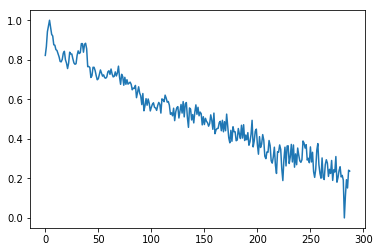

In [4]:
plt.plot(dataset)   
plt.show()

In [5]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [6]:
# 훈련은 0~10으로 테스트는 11로

look_back = param_window_size

trainX, trainY = create_dataset(dataset, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

testX, testY = create_dataset(dataset, look_back)
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [7]:
%%time
theano.config.compute_test_value = "ignore"

# create and fit the LSTM network
batch_size = 1
model = Sequential()

for i in range(param_lstm_stack):
    model.add(LSTM(param_lstm_units, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    model.add(Dropout(0.3))
model.add(LSTM(param_lstm_units, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

CPU times: user 1.39 s, sys: 123 ms, total: 1.51 s
Wall time: 2.04 s


In [8]:
for epoch_idx in range(param_num_epoch):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2, shuffle=False)
    model.reset_states()

Epoch 1/1
4s - loss: 0.0267
Epoch 1/1
4s - loss: 0.0141
Epoch 1/1
4s - loss: 0.0143
Epoch 1/1
4s - loss: 0.0135
Epoch 1/1
4s - loss: 0.0129
Epoch 1/1
4s - loss: 0.0124
Epoch 1/1
4s - loss: 0.0133
Epoch 1/1
4s - loss: 0.0148
Epoch 1/1
4s - loss: 0.0143
Epoch 1/1
4s - loss: 0.0157
Epoch 1/1
4s - loss: 0.0113
Epoch 1/1
4s - loss: 0.0086
Epoch 1/1
4s - loss: 0.0081
Epoch 1/1
4s - loss: 0.0098
Epoch 1/1
4s - loss: 0.0180
Epoch 1/1
4s - loss: 0.0193
Epoch 1/1
4s - loss: 0.0223
Epoch 1/1
4s - loss: 0.0272
Epoch 1/1
4s - loss: 0.0274
Epoch 1/1
4s - loss: 0.0285
Epoch 1/1
4s - loss: 0.0290
Epoch 1/1
3s - loss: 0.0285
Epoch 1/1
3s - loss: 0.0288
Epoch 1/1
4s - loss: 0.0289
Epoch 1/1
3s - loss: 0.0289
Epoch 1/1
3s - loss: 0.0289
Epoch 1/1
4s - loss: 0.0293
Epoch 1/1
4s - loss: 0.0297
Epoch 1/1
3s - loss: 0.0296
Epoch 1/1
3s - loss: 0.0297
Epoch 1/1
4s - loss: 0.0297
Epoch 1/1
4s - loss: 0.0295
Epoch 1/1
4s - loss: 0.0300
Epoch 1/1
4s - loss: 0.0303
Epoch 1/1
4s - loss: 0.0294
Epoch 1/1
4s - loss:

In [9]:
testScore = model.evaluate(testX, testY, batch_size=batch_size, verbose=0)
print('Test Score: ', testScore)

model.reset_states()

('Test Score: ', 0.031463143899345375)


In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 287), ylim=(0, 1))

plotcols = ["blue","red"]

lines = []

test_seq_size = param_seq_length - param_window_size
    
for i in range(2):
    lobj = ax.plot([],[],lw=1,color=plotcols[i])[0]
    lines.append(lobj)

def init():
    for line in lines:
        line.set_data([],[])
    return lines

def animate(curr_idx):

    predictions = np.zeros((test_seq_size, 1))
    testPredict = [np.vstack([testX[0][:]])]

    look_hist = curr_idx
    look_ahead = test_seq_size - curr_idx

    for i in range(look_hist):
        prediction = model.predict(np.array([testPredict[-1]]), batch_size=1)
        predictions[i] = testY[i]
        testPredict.append(np.vstack([testX[i+1][:]]))
        
    for i in range(look_ahead):    
        prediction = model.predict(np.array([testPredict[-1]]), batch_size=1)
        predictions[i + look_hist] = prediction
        testPredict.append(np.vstack([testPredict[-1][1:],prediction]))
    
    model.reset_states()
    
    x = np.linspace(0, test_seq_size-1, test_seq_size)
    y = [testY, predictions]
    
    #for index in range(0,1):
    for i, line in enumerate(lines):
        line.set_data(x, y[i]) # set data for each line separately. 

    return lines

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=test_seq_size, interval=20, blit=True)

result_filename = 'w' + str(param_window_size) + '_' + 'u' + str(param_lstm_units) + '_' + 's' + str(param_lstm_stack) + '_' + 'e' + str(param_num_epoch)

anim.save( result_filename + '.gif', writer='imagemagick', fps=30, dpi=100)

plt.show()

In [11]:
test_seq_size

248

In [12]:
testX[0][:]

array([[ 0.82213795],
       [ 0.86602795],
       [ 0.94235533],
       [ 0.97077185],
       [ 1.        ],
       [ 0.96257025],
       [ 0.92847151],
       [ 0.92042321],
       [ 0.87592691],
       [ 0.87397718],
       [ 0.85149956],
       [ 0.84719396],
       [ 0.83153284],
       [ 0.81486058],
       [ 0.7914418 ],
       [ 0.78954929],
       [ 0.80225658],
       [ 0.83382905],
       [ 0.84281534],
       [ 0.7999211 ],
       [ 0.7832315 ],
       [ 0.75567359],
       [ 0.78267473],
       [ 0.83836126],
       [ 0.82921594],
       [ 0.82921594],
       [ 0.80482703],
       [ 0.78406435],
       [ 0.77732491],
       [ 0.78015441],
       [ 0.82213795],
       [ 0.84501398],
       [ 0.83153284],
       [ 0.83610511],
       [ 0.88168919],
       [ 0.88168919],
       [ 0.83836126],
       [ 0.87786198],
       [ 0.8835817 ],
       [ 0.85573459]], dtype=float32)

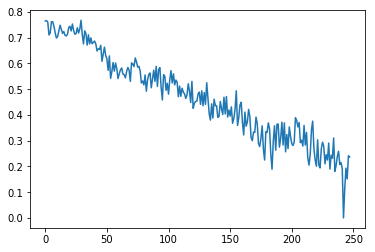

In [17]:
plt.plot(testY) 
plt.show()

In [ ]:
predictions